<p style="font-size: 40px; font-weight: bold; text-align: center;">
  Galaxies Clustering Project 
</p>

## Dataset
**Data source:** [Galaxy Zoo 2 | Kaggle](https://www.kaggle.com/datasets/jaimetrickz/galaxy-zoo-2-images)
- dataset contains 243k images of galaxies


## Business goal
Automatic Classification of Galaxies
- Automate the process of classifying galaxies 
- Reduce the time and effort required to classify galaxies



### Importing the libraries

In [1]:
import cv2 as cv
from PIL import Image

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from utils import find_extensions, read_filenames, show_galaxies

In [2]:
path = '/Users/michal/Documents/studia/sem4/WdUM/Galaxies_Clusterization/data/images'
#path = '/Users/julia/Desktop/semestr-4/ml/projekty/projekt-2/galaxies_data/images_gz2/images'
os.chdir(path)

In [7]:
extensions = find_extensions(path)
print(extensions.keys())

dict_keys(['.jpg', '', '.txt'])


In [8]:
print(extensions['.txt'], extensions[''])

['results', 'results_public'] ['z']


In [5]:
!wc -l results.txt
!wc -l results_public.txt

   59979 results.txt
   19992 results_public.txt


In [3]:
galaxies = read_filenames(path)

In [10]:
print(galaxies[:10])

['9733.jpg', '110369.jpg', '14147.jpg', '86425.jpg', '52112.jpg', '108526.jpg', '222363.jpg', '139923.jpg', '89716.jpg', '63.jpg']


In [8]:
heights = set()
widths = set()

for galaxy in galaxies:
    with Image.open(galaxy) as img:
        width, height = img.size
        heights.add(height)
        widths.add(width)

print(f'Heights: {heights}')
print(f'Widths: {widths}')

Heights: {424}
Widths: {424}


All images have the same size: 424 x 424

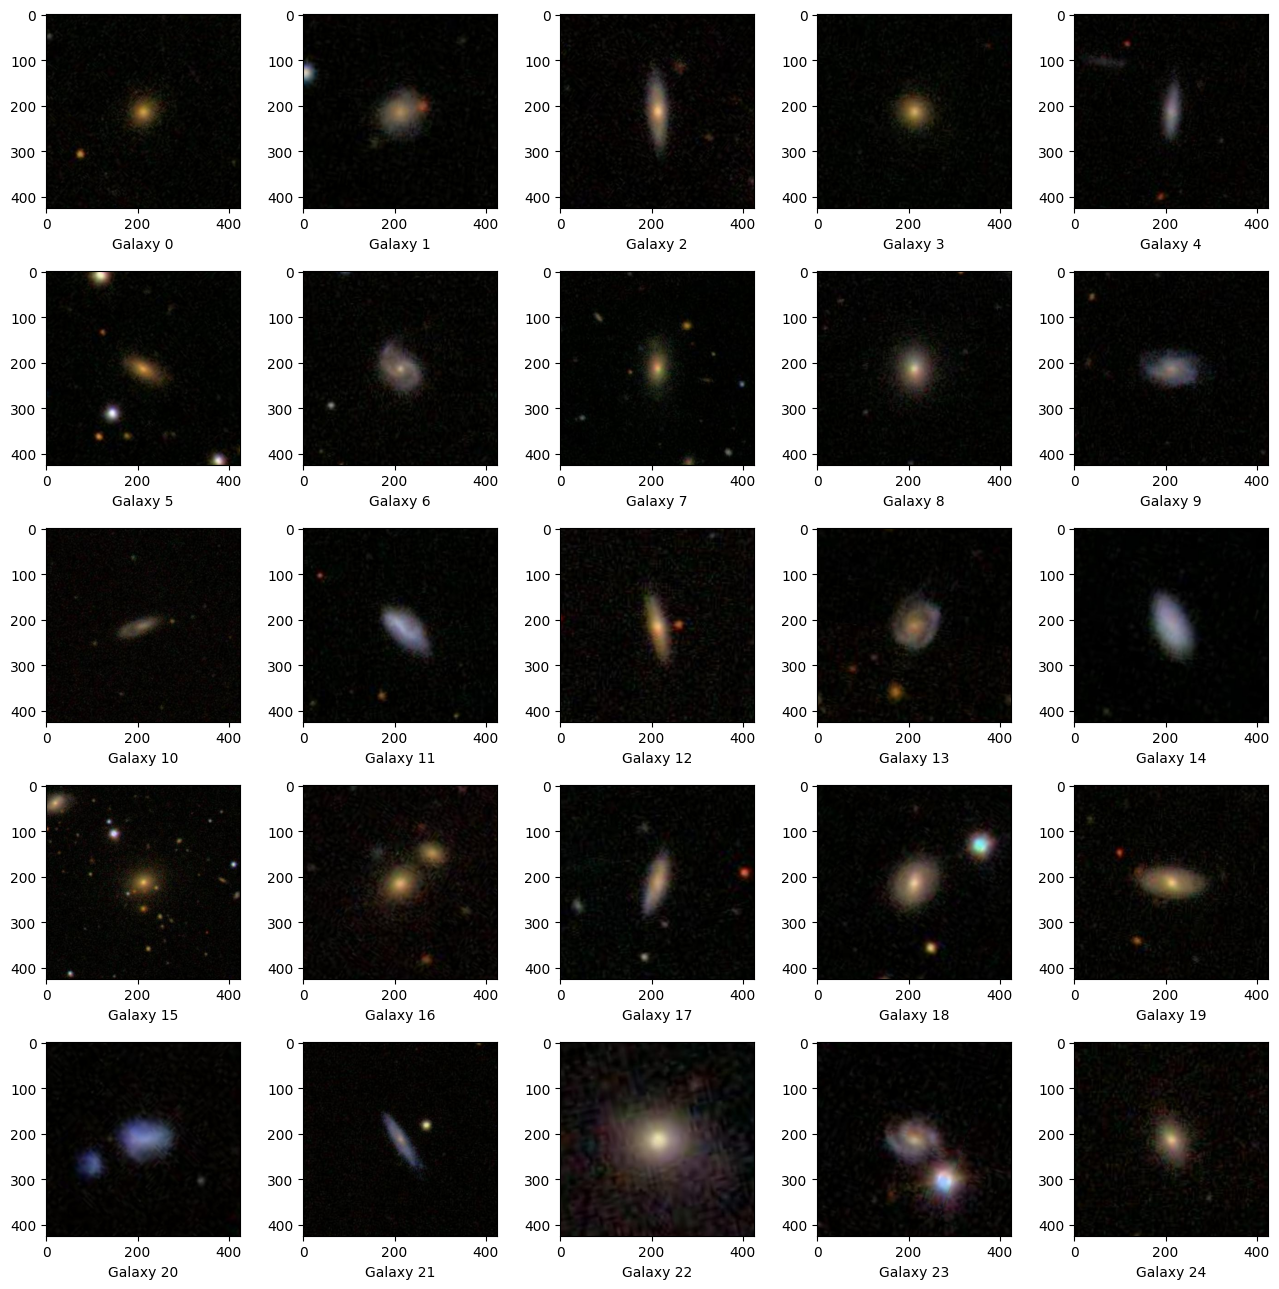

In [4]:
show_galaxies(galaxies) # Set rand = True to explore random galaxies

Galaxies are located in the center of the image, so we will cut them.
(Later another, more clever approach to cutting will be taken - see processing notebook)

In [5]:
def show_galaxy(ind, cut = True):
    if isinstance(ind, int):
        ind = galaxies[ind]
    elif not isinstance(ind, str):
        raise TypeError()    

    img = plt.imread(ind)
    if cut:
        img = img[110:310,110:310]
    plt.xlabel(f'Galaxy {ind}')
    plt.imshow(img)

Before cutting

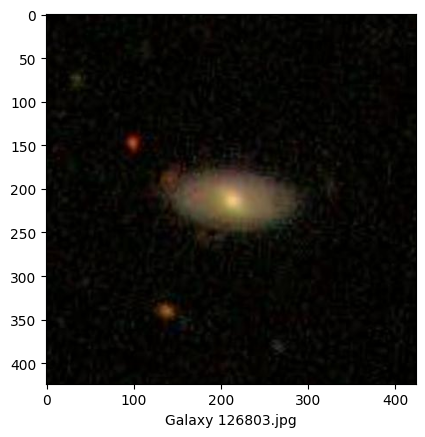

In [35]:
show_galaxy(19, False)

After cutting

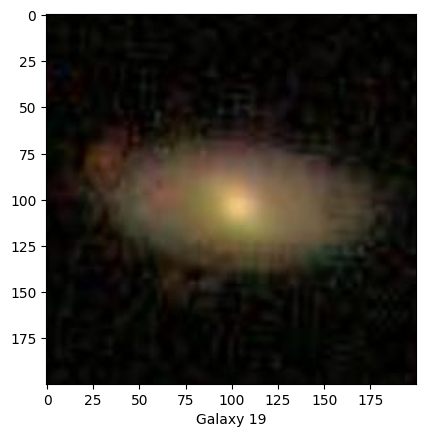

In [11]:
show_galaxy(19)

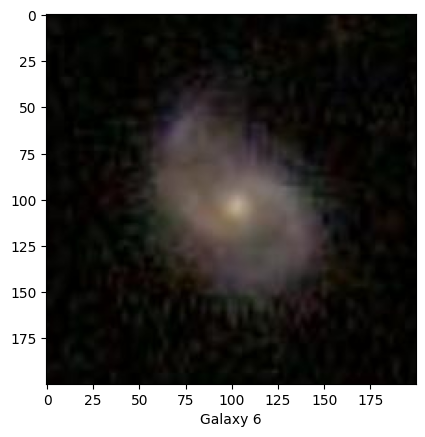

In [12]:
show_galaxy(6)

### Potential outliers

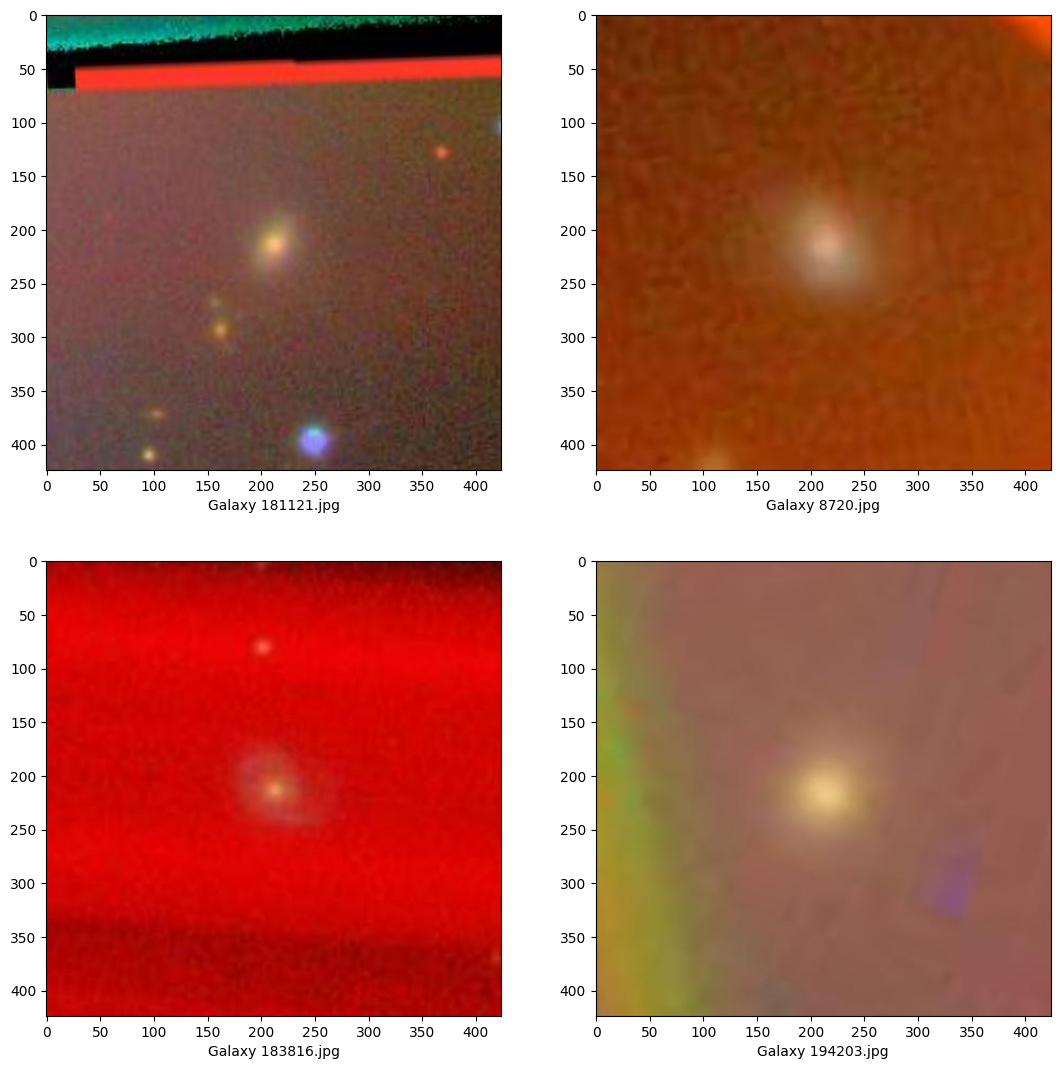

In [38]:
outliers = ['181121.jpg', '8720.jpg', '183816.jpg', '194203.jpg']

figure, axes = plt.subplots(nrows=2,ncols=2,figsize=(13,13))
for i, ax in enumerate(axes.flat):
    img = plt.imread(outliers[i])
    ax.imshow(img)
    ax.set_xlabel(f'Galaxy {outliers[i]}')

### Brightness and color analysis

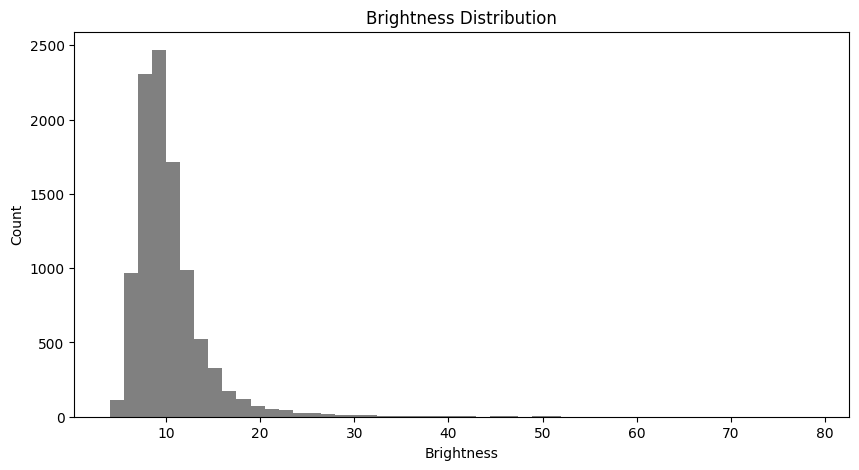

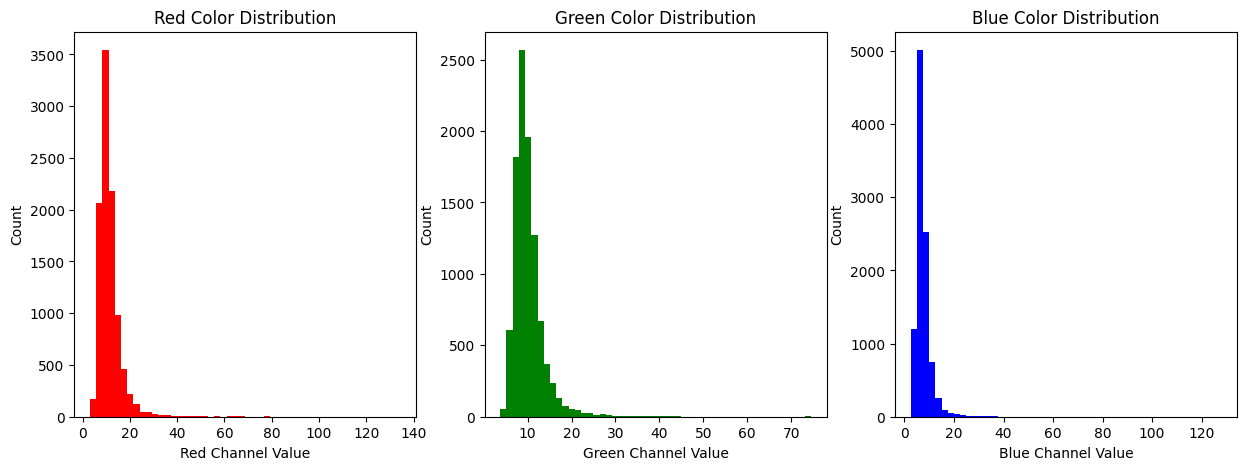

In [7]:
# Function to read images from the directory using the list of file names
def load_galaxies(file_names, max_images=10000):
    images = []
    for i, file_name in enumerate(file_names):
        if i < max_images:
            image = cv.imread(file_name)
            if image is not None:
                images.append(image)
    return images

# Function to calculate brightness of an image
def calculate_brightness(image):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return np.mean(gray_image)

# Function to extract color features
def extract_color_features(image):
    mean_color = cv.mean(image)[:3]  # Mean color in BGR format
    return mean_color

images = load_galaxies(galaxies)
brightness_values = [calculate_brightness(galaxy_image) for galaxy_image in images]
color_features = np.array([extract_color_features(galaxy_image) for galaxy_image in images])

# Plot brightness distribution
plt.figure(figsize=(10, 5))
plt.boxplot(brightness_values, bins=50, color='gray')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Count')
plt.show()

# Plot color distributions
plt.figure(figsize=(15, 5))

# Red channel
plt.subplot(1, 3, 1)
plt.boxplot(color_features[:, 2], bins=50, color='red')
plt.title('Red Color Distribution')
plt.xlabel('Red Channel Value')
plt.ylabel('Count')

# Green channel
plt.subplot(1, 3, 2)
plt.boxplot(color_features[:, 1], bins=50, color='green')
plt.title('Green Color Distribution')
plt.xlabel('Green Channel Value')
plt.ylabel('Count')

# Blue channel
plt.subplot(1, 3, 3)
plt.boxplot(color_features[:, 0], bins=50, color='blue')
plt.title('Blue Color Distribution')
plt.xlabel('Blue Channel Value')
plt.ylabel('Count')

plt.show()

### Binary thresholding

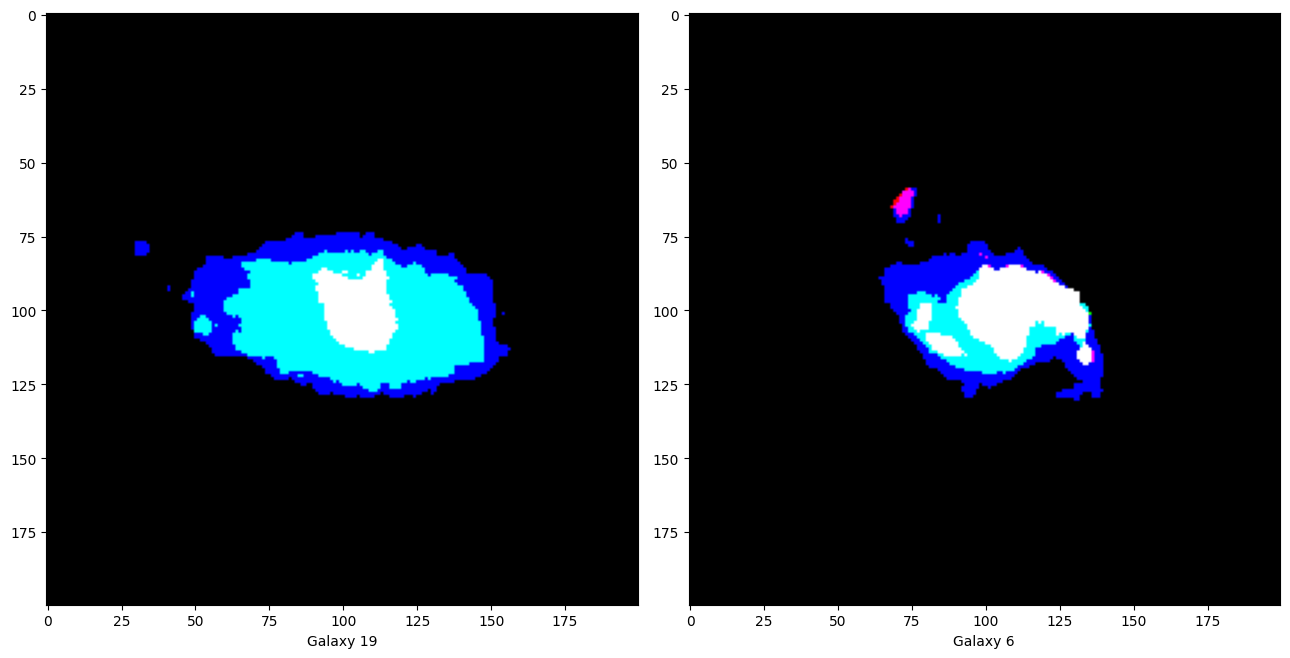

In [63]:
figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(13,13))
indices = (19, 6)

for i, ax in zip(indices, axis.flat):
    img = cv.imread(galaxies[i])
    cut_img = img[110:310,110:310]
    _, Thresh_IMG = cv.threshold(cut_img, 90, 255, cv.THRESH_BINARY)
    ax.imshow(Thresh_IMG, cmap='Greys_r')
    ax.set_xlabel(f'Galaxy {i}')

plt.tight_layout()
plt.show()

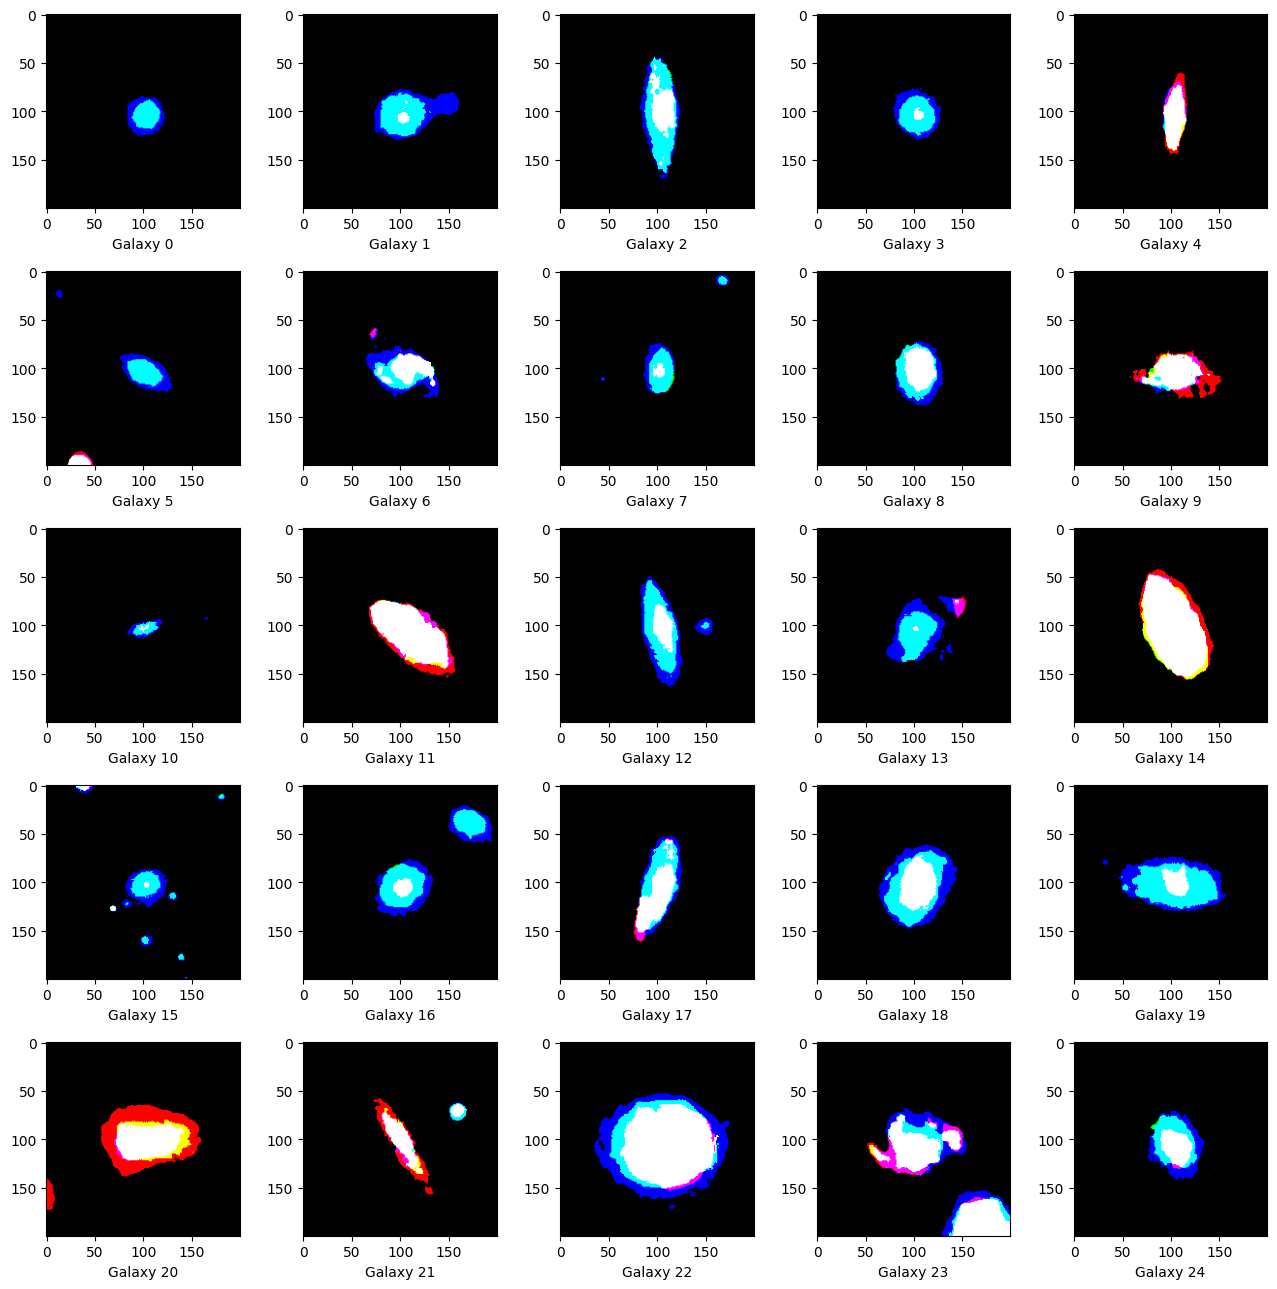

In [80]:
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(13,13))

for i,ax in enumerate(axis.flat):
    img = cv.imread(galaxies[i])
    cut_img = img[110:310,110:310]
    _,Thresh_IMG = cv.threshold(cut_img, 90, 255, cv.THRESH_BINARY)
    ax.imshow(Thresh_IMG, cmap='Greys_r')
    ax.set_xlabel(f'Galaxy {i}')
plt.tight_layout()
plt.show()

### Size of galaxies

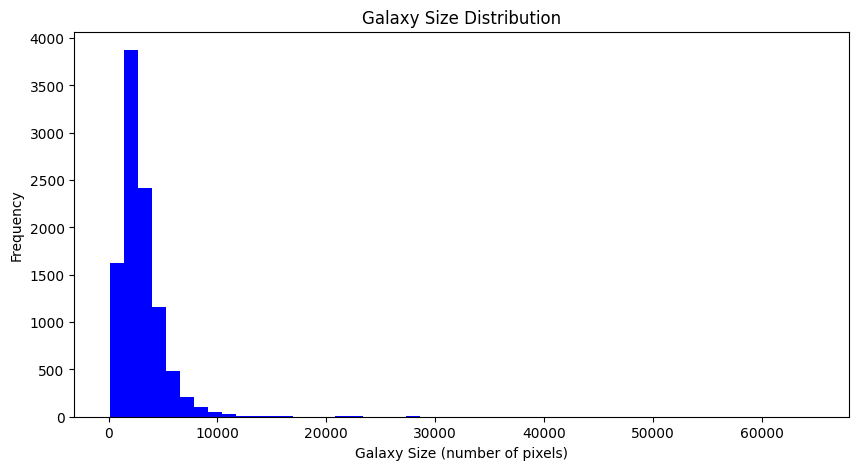

In [8]:
def calculate_galaxy_size(image, threshold=90):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, binary_image = cv.threshold(gray_image, threshold, 255, cv.THRESH_BINARY)
    galaxy_size = cv.countNonZero(binary_image)
    return galaxy_size

galaxy_sizes = [calculate_galaxy_size(galaxy_image) for galaxy_image in images]

# Plot galaxy size distribution
plt.figure(figsize=(10, 5))
plt.hist(galaxy_sizes, bins=50, color='blue')
plt.title('Galaxy Size Distribution')
plt.xlabel('Galaxy Size (number of pixels)')
plt.ylabel('Frequency')
plt.show()

### Contour detection

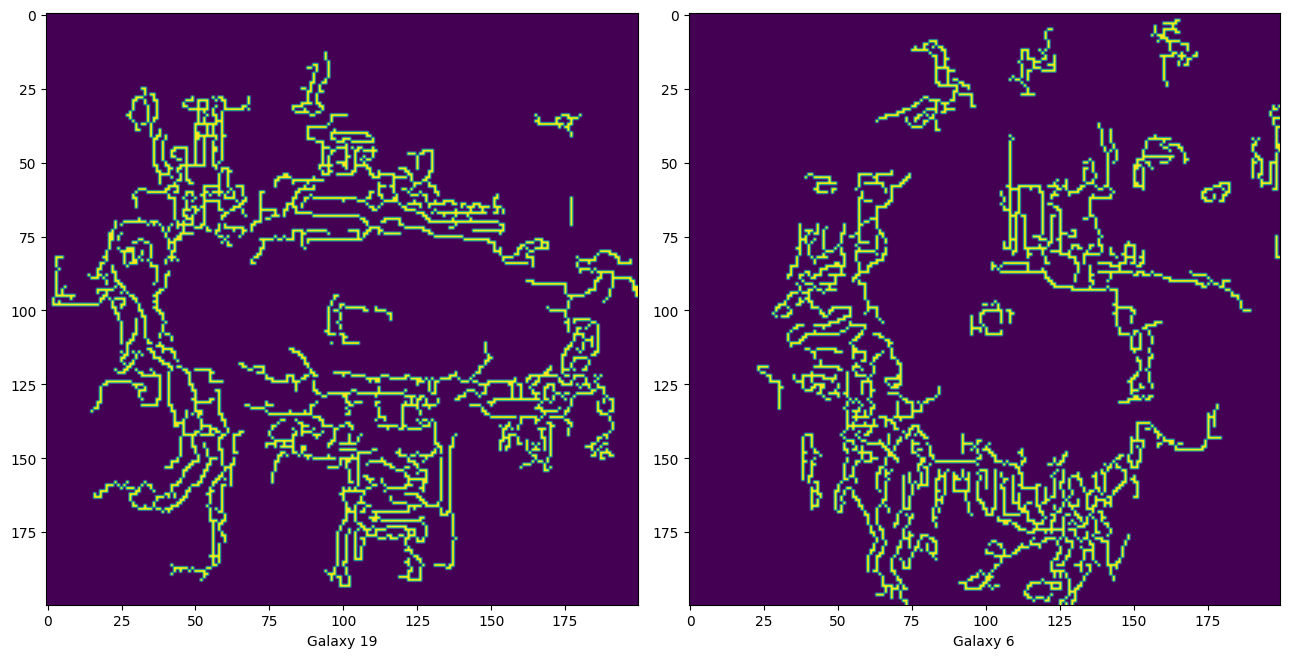

In [70]:
figure,axis = plt.subplots(nrows=1,ncols=2,figsize=(13,13))

for i,ax in zip(indices, axis.flat):
    img = cv.imread(galaxies[i], 0)
    cut_img = img[110:310,110:310]
    canny_img = cv.Canny(cut_img, 5, 80)
    contour,_ = cv.findContours(canny_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    draw_contour = cv.drawContours(canny_img, contour, -1, (255,0,0), 1)
    ax.set_xlabel(f'Galaxy {i}')
    ax.imshow(draw_contour)
plt.tight_layout()
plt.show()

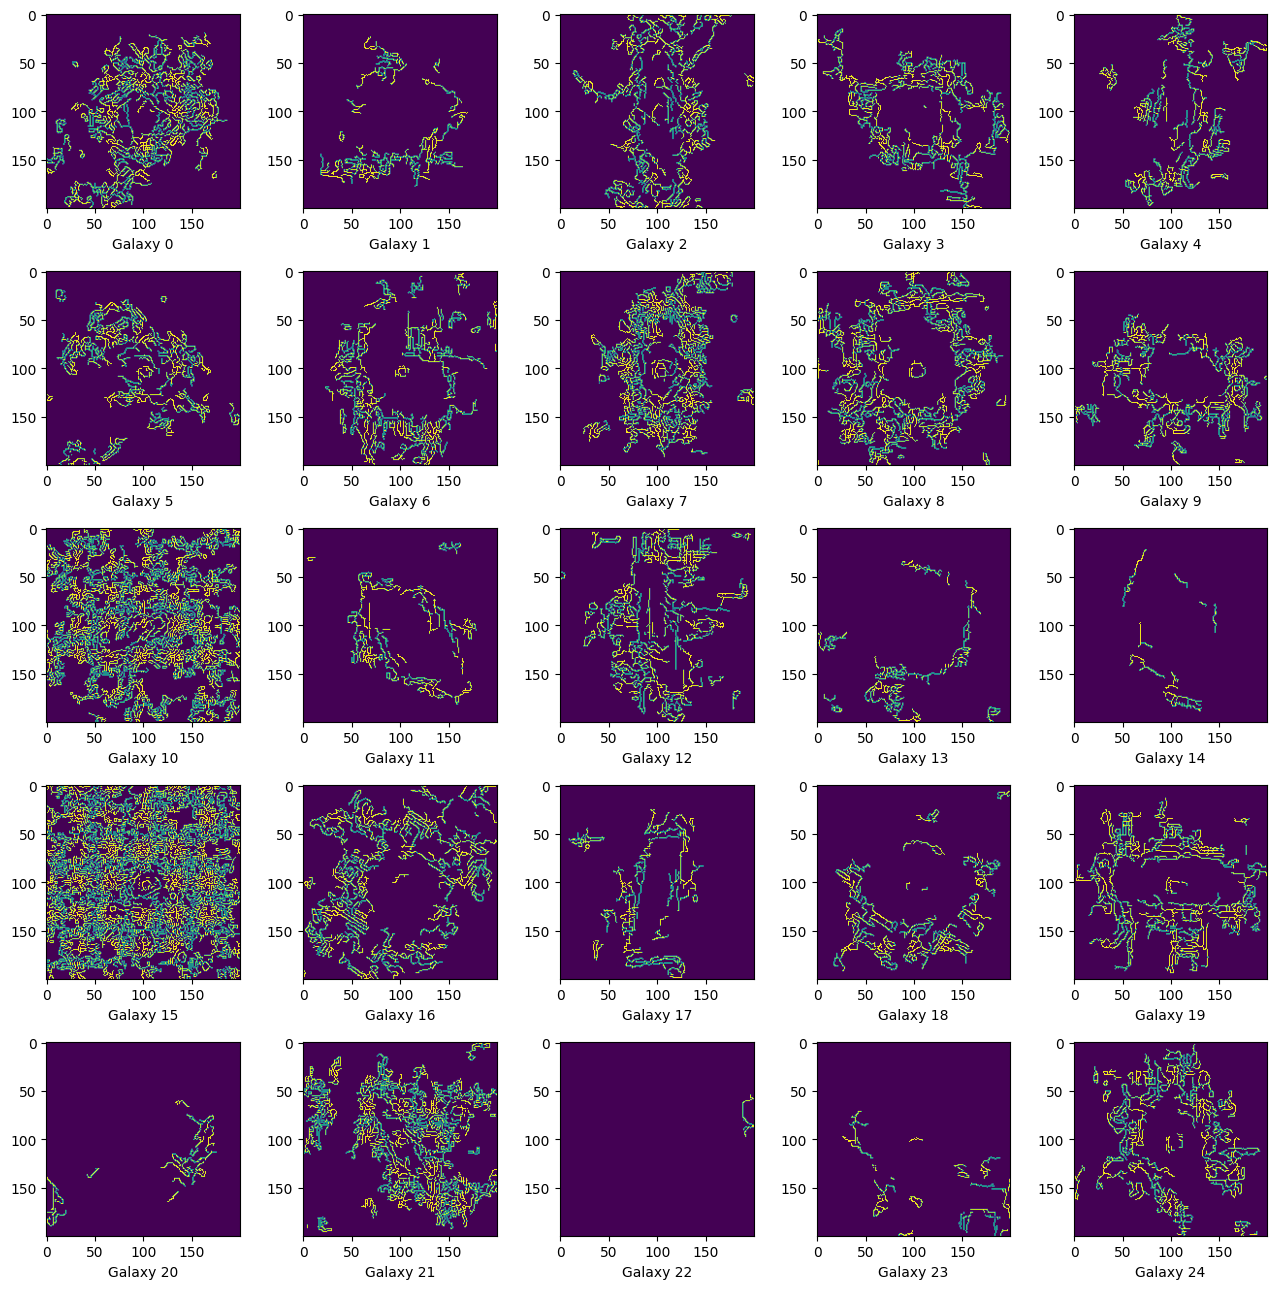

In [69]:
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(13,13))

for i,ax in enumerate(axis.flat):
    img = cv.imread(galaxies[i], 0)
    cut_img = img[110:310,110:310]
    canny_img = cv.Canny(cut_img, 5, 80)
    contour,_ = cv.findContours(canny_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    draw_contour = cv.drawContours(canny_img, contour, -1, (255,0,0), 1)
    ax.set_xlabel(f'Galaxy {i}')
    ax.imshow(draw_contour)
plt.tight_layout()
plt.show()

### Absolute difference

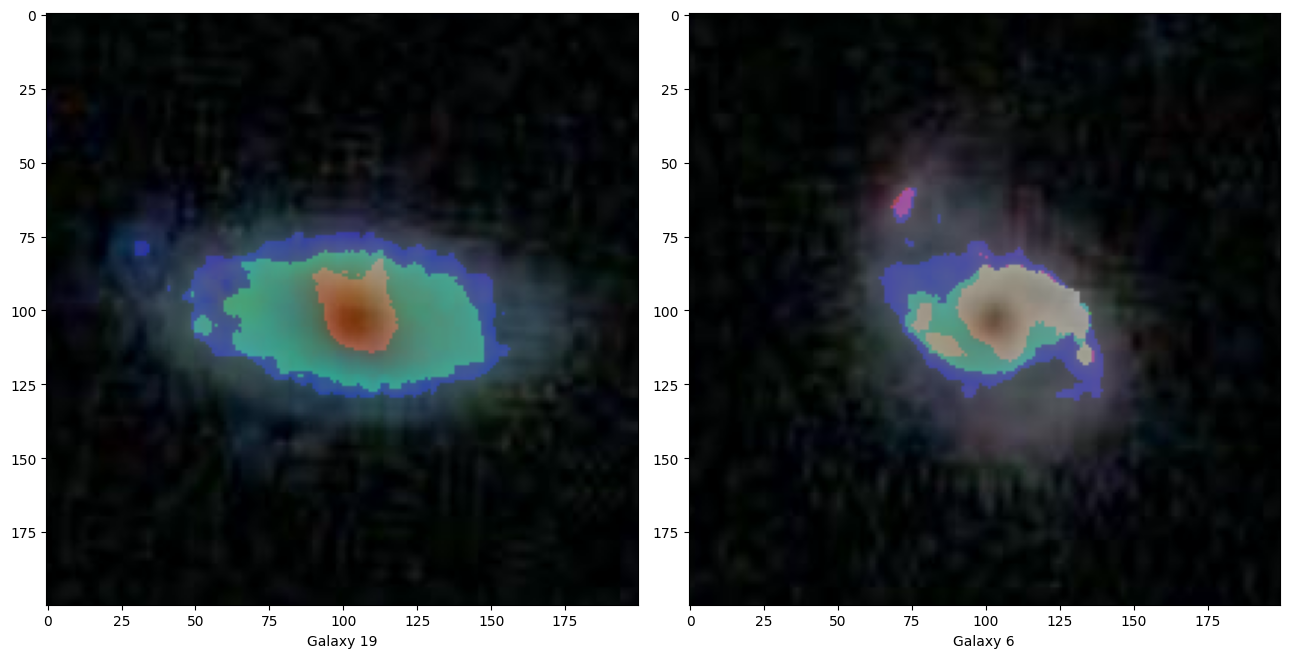

In [72]:
figure,axis = plt.subplots(nrows=1,ncols=2,figsize=(13,13))

for i,ax in zip(indices, axis.flat):
    img = cv.imread(galaxies[i])
    cut_img = img[110:310,110:310]
    canny_img = cv.Canny(cut_img, 5, 80)
    _, thresh_img = cv.threshold(cut_img, 90, 255, cv.THRESH_BINARY)
    diff_img = cv.absdiff(cut_img, thresh_img)
    ax.set_xlabel(f'Galaxy {i}')
    ax.imshow(diff_img)
plt.tight_layout()
plt.show()

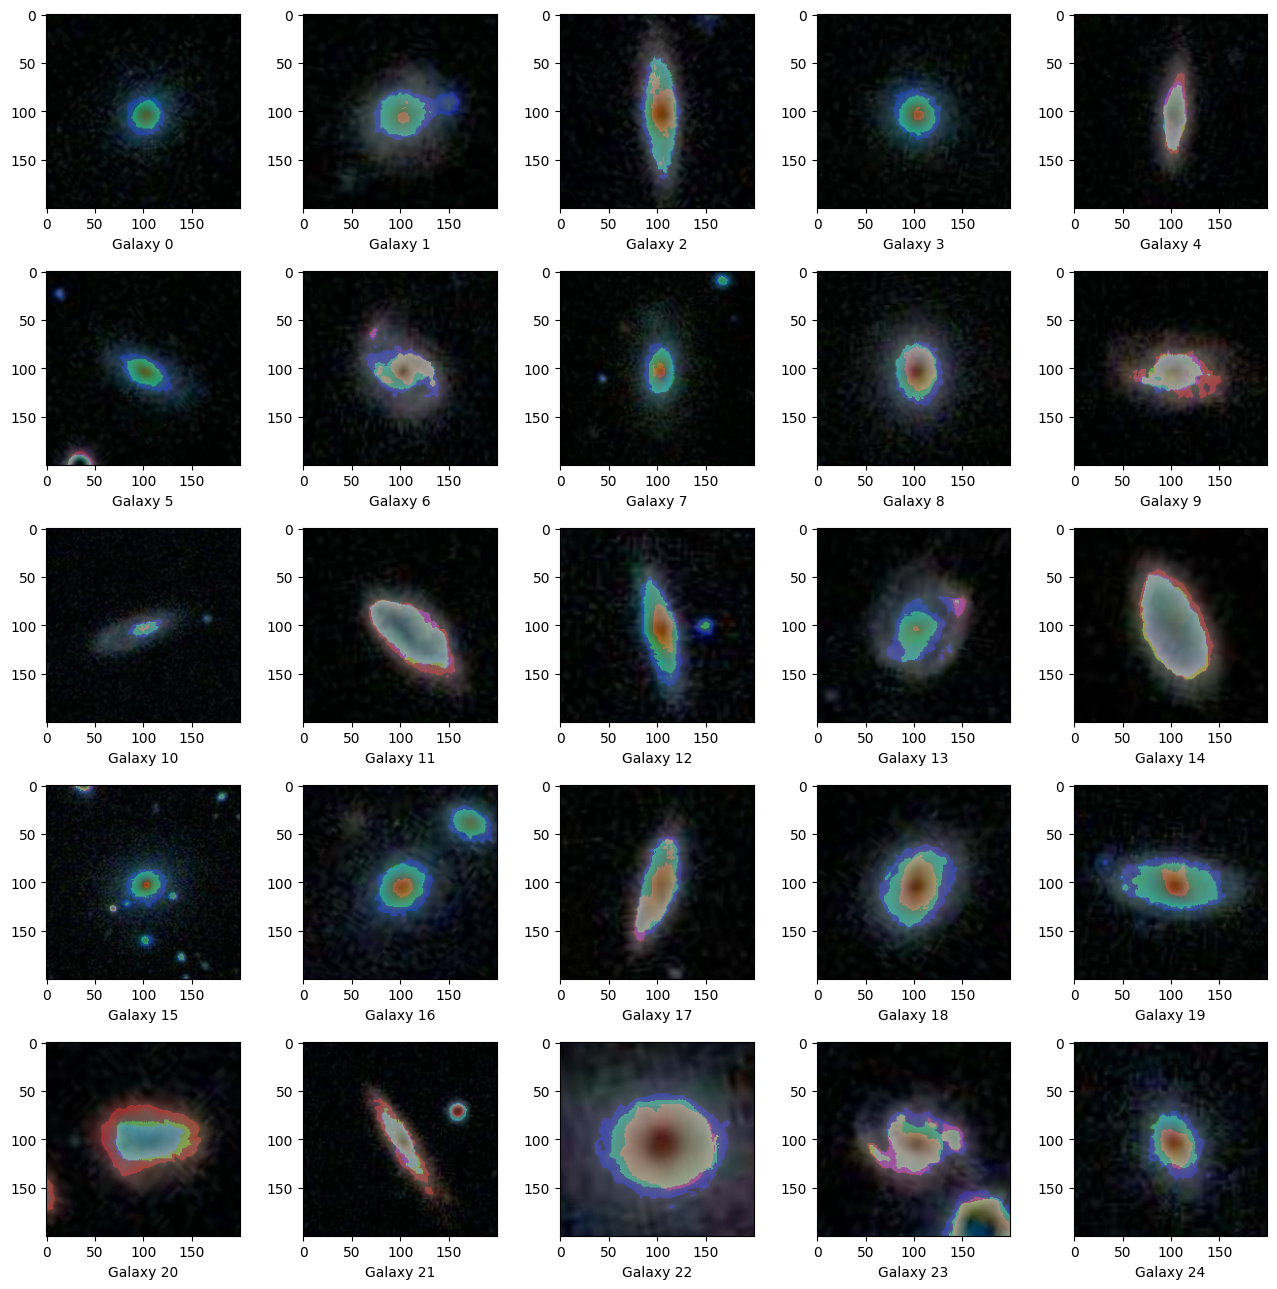

In [73]:
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(13,13))

for i,ax in enumerate(axis.flat):
    img = cv.imread(galaxies[i])
    cut_img = img[110:310,110:310]
    canny_img = cv.Canny(cut_img, 5, 80)
    _, thresh_img = cv.threshold(cut_img, 90, 255, cv.THRESH_BINARY)
    diff_img = cv.absdiff(cut_img, thresh_img)
    ax.set_xlabel(f'Galaxy {i}')
    ax.imshow(diff_img)
plt.tight_layout()
plt.show()

### Contour detection (bounding rectangle)

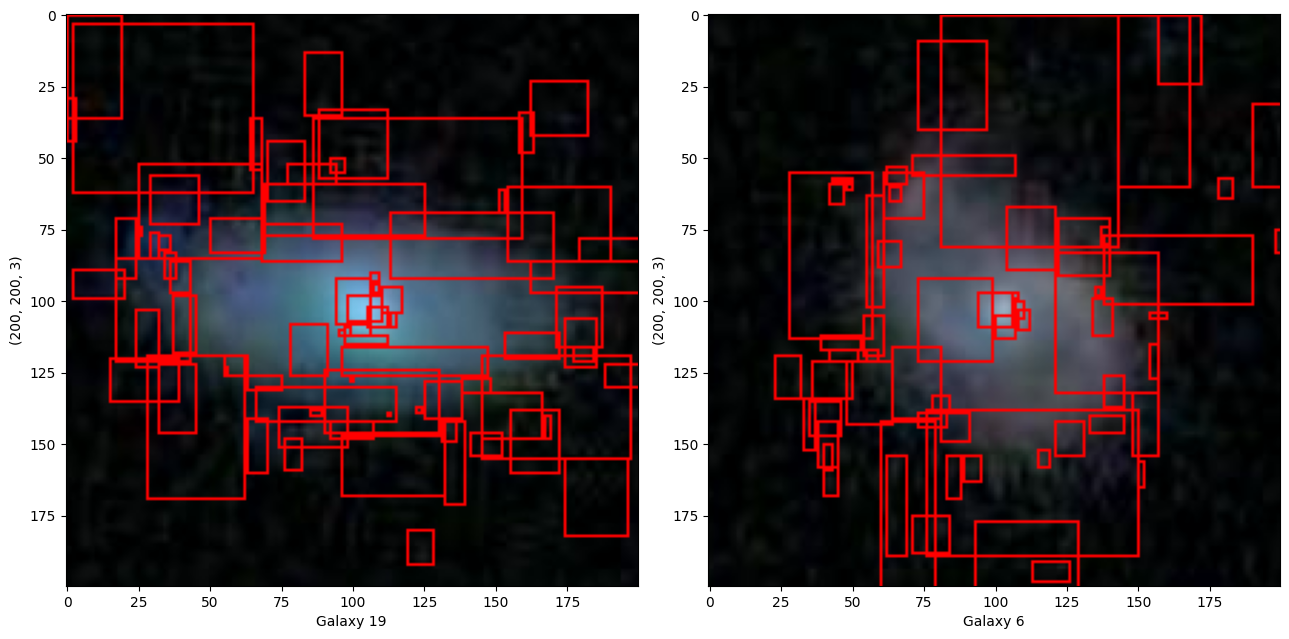

In [79]:
figure,axis = plt.subplots(nrows=1,ncols=2,figsize=(13,13))

for i,ax in zip(indices, axis.flat):
    img = cv.imread(galaxies[i])
    cut_img = img[110:310,110:310]
    canny_img = cv.Canny(cut_img, 5, 80)
    contour,_ = cv.findContours(canny_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    for cnt in contour:
        x,y,w,h = cv.boundingRect(cnt)
        cv.rectangle(cut_img,(x,y),(x+w,y+h),(255,0,0),1)
    ax.imshow(cut_img, cmap='Greys_r')
    ax.set_xlabel(f'Galaxy {i}')
    ax.set_ylabel(cut_img.shape)
plt.tight_layout()
plt.show()

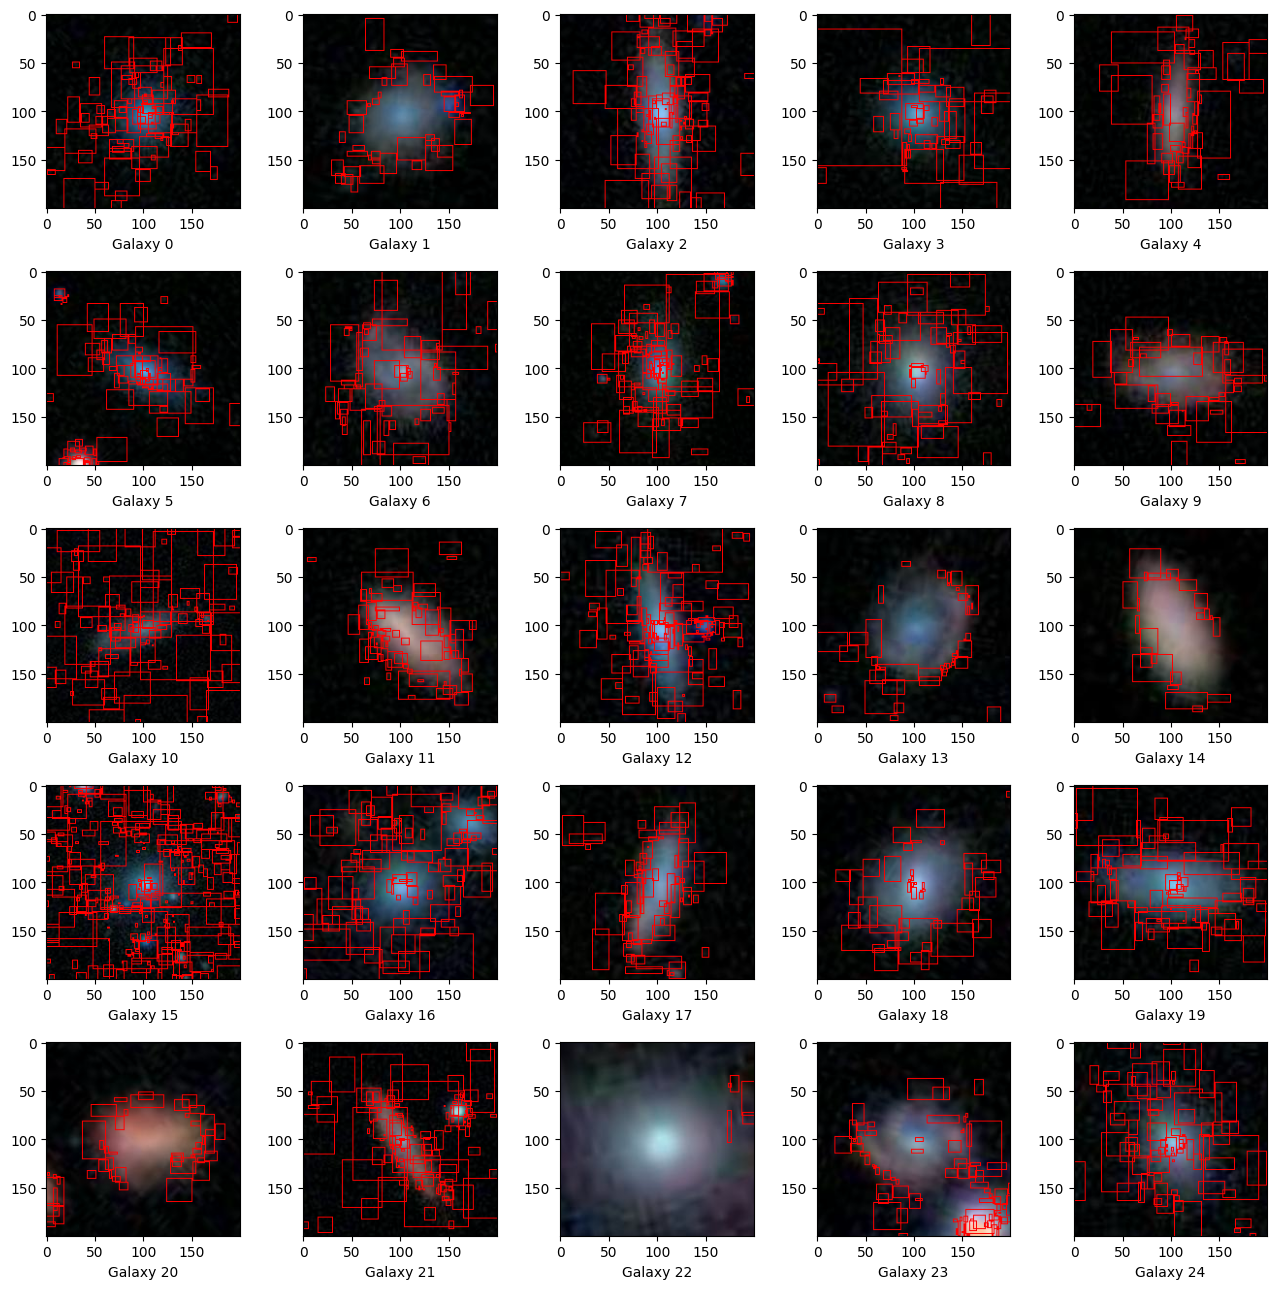

In [78]:
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(13,13))

for i,ax in enumerate(axis.flat):
    img = cv.imread(galaxies[i])
    cut_img = img[110:310,110:310]
    canny_img = cv.Canny(cut_img, 5, 80)
    contour,_ = cv.findContours(canny_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    for cnt in contour:
        x,y,w,h = cv.boundingRect(cnt)
        cv.rectangle(cut_img,(x,y),(x+w,y+h),(255,0,0),1)
    ax.imshow(cut_img, cmap='Greys_r')
    ax.set_xlabel(f'Galaxy {i}')
plt.tight_layout()
plt.show()